In [23]:
import pandas as pd
import numpy as np
import scanpy as sc
from anndata import AnnData
import scipy

import random
import leidenalg
import louvain
import time
import math

In [24]:
adata = sc.read_h5ad("Greenham/Data/Greenham.h5ad")

In [25]:
# Copy the 'counts' layer to 'X'
adata.X = adata.layers['counts'].copy()

In [26]:
np.any(np.isnan(adata.X.data))

False

In [27]:
adata.obs['phase'] = adata.obs['orig.ident'].str.extract(r'(\d+)')[0]

The Seurat Umap from Greenham with her clustering

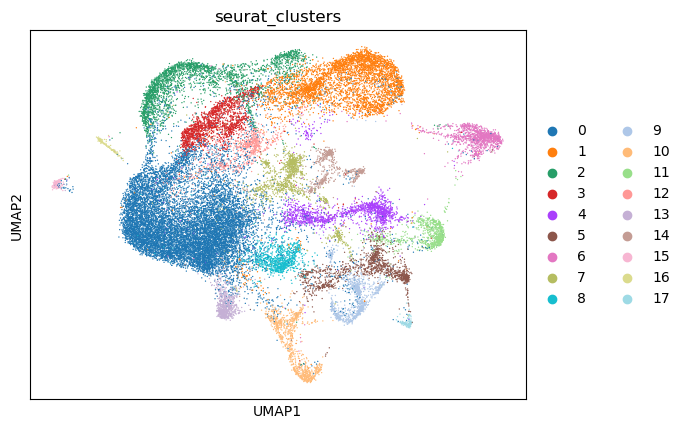

In [28]:
sc.pl.umap(adata, color='seurat_clusters')  # replace 'gene1', 'gene2' with the names of genes or metadata you want to color by

Calculate my own UMAP, color by Greenham's clusters

In [29]:
print(type(adata.X))
print(adata.X.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(32028, 25249)


In [30]:
adata.var['highly_variable'] = adata.var['highly_variable'] == 1

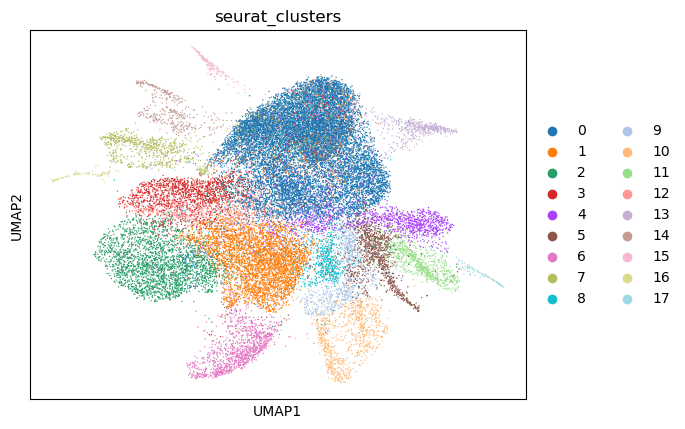

In [31]:
# If UMAP has not been computed, compute it (optional)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform the data
sc.pp.log1p(adata)

# # Identify highly variable genes (optional)
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# # Subset to highly variable genes (optional)
# adata = adata[:, adata.var.highly_variable]

# Scale the data to unit variance and zero mean
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=30)

sc.pp.neighbors(adata, use_rep = 'X_pca', n_neighbors= 20)
sc.tl.umap(adata)

# Plot the UMAP
sc.pl.umap(adata, color='seurat_clusters')  # replace 'gene1', 'gene2' with the names of genes or metadata you want to color by


Create a Pseudobulk

In [32]:
num_subjects = len(np.unique(adata.obs['orig.ident']))

pseudobulk_samples = np.zeros((num_subjects, len(adata.var.index)))

# Group by subjects and sum the expression counts
grouped = adata.obs.groupby('orig.ident').indices

for sub, cell_indices in grouped.items():
    sub_idx = list(grouped.keys()).index(sub)
    pseudobulk_samples[sub_idx, :] = adata.layers['counts'][cell_indices, :].sum(axis=0)

# Create a new AnnData object for pseudobulk samples
adata_pseudobulk = AnnData(X=pseudobulk_samples)
adata_pseudobulk.obs['subject'] = np.unique(adata.obs['orig.ident'])
adata_pseudobulk.var = adata.var
# Print the shape of the pseudobulk samples
print("Pseudobulk samples shape:", adata_pseudobulk.X.shape)

# Display the pseudobulk data
print("Pseudobulk data:")
print(adata_pseudobulk.X)
adata

Pseudobulk samples shape: (14, 25249)
Pseudobulk data:
[[   3.   16. 1259. ...    0.    0.    0.]
 [   0.   13.  575. ...    0.    0.    0.]
 [   0.    6.  598. ...    0.    0.    0.]
 ...
 [   0.   14.  561. ...    0.    0.    0.]
 [   0.   21.  950. ...    0.    0.    0.]
 [   0.    5.  298. ...    0.    0.    0.]]


/var/folders/td/r_9nz29j4tjbp3ck1k26xf840000gn/T/ipykernel_11275/3450210273.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby('orig.ident').indices


AnnData object with n_obs × n_vars = 32028 × 25249
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.cyc', 'percent.mt', 'percent.cp', 'multiplet', 'Barcodes', 'day', 'RNA_snn_res.0.3', 'seurat_clusters', 'phase'
    var: 'highly_variable', 'mean', 'std'
    uns: 'pca', 'seurat_clusters_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'nn', 'snn', 'distances', 'connectivities'

In [33]:
subjects = [list(grouped.keys()).index(i) for i in adata.obs['orig.ident']]
subjects_vect = np.array(subjects).astype(np.int32).reshape(1, -1)

In [34]:
# List of core clock genes
genes_of_interest = ['AT3G09600','AT5G17300','AT1G01060','AT2G46830','AT3G54500','AT5G06980',
                     'AT3G12320','AT5G02810','AT5G37260','AT2G25930','AT5G61380','AT4G39260', 'AT2G21660'] 
#took out AT1G01520 with low expression

# Ensure that the gene names exist in the AnnData object
genes_of_interest = [gene for gene in genes_of_interest if gene in adata_pseudobulk.var_names]

# Subset the AnnData object
adata_subset = adata_pseudobulk[:, genes_of_interest]

emat = adata_subset.X
refmat = np.array(scipy.stats.spearmanr(emat))[0,:,:]

# Extract the gene symbols from 'adata.vars'
gene_symbols = adata.var.index  # Assuming the gene symbols are the index of 'adata.var'

# Create a dictionary mapping gene symbols to their corresponding indices
gene_indices = {gene: idx for idx, gene in enumerate(gene_symbols)}

# Get the indices of the genes of interest in the same order as 'gene_list'
indices_list = [gene_indices[gene] for gene in genes_of_interest if gene in gene_indices]

print(indices_list)


[13698, 9374, 618, 18594, 11481, 7742, 13960, 6197, 8398, 19407, 8363, 21009, 19500]


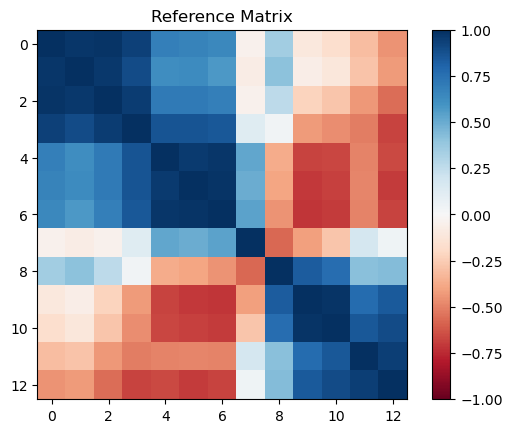

In [35]:
import matplotlib.pyplot as plt

plt.imshow( refmat, cmap = "RdBu" ,vmin=-1, vmax=1)
plt.colorbar()
plt.title( "Reference Matrix" )
plt.show()

In [36]:
from scanpy import _utils
import importlib
import warnings
from scanpy import logging as logg
from scipy import sparse
# from scanpy.tools._compat import old_positionals
from scanpy._utils import _choose_graph
from scanpy.tools._utils_clustering import rename_groups, restrict_adjacency
from natsort import natsorted
from collections.abc import Sequence
from types import MappingProxyType
from scipy.sparse import spmatrix
from collections.abc import Mapping, Sequence

try:
    from leidenalg.VertexPartition import MutableVertexPartition
except ImportError:

    class MutableVertexPartition:
        pass

    MutableVertexPartition.__module__ = "leidenalg.VertexPartition"
try:
    from louvain.VertexPartition import MutableVertexPartition
except ImportError:

    class MutableVertexPartition:
        pass

    MutableVertexPartition.__module__ = "louvain.VertexPartition"

from typing import TYPE_CHECKING, Literal, Any

#interface my custom clustering with scanpy:
def ccdCluster_leiden(
    adata: AnnData,
    emat,
    refmat,
    resolution: float = 1,
    *,
    restrict_to: tuple[str, Sequence[str]] | None = None,
    random_state: _utils.AnyRandom = 0,
    key_added: str = "louvainccd",
    adjacency: sparse.spmatrix | None = None,
    directed: bool | None = None,
    use_weights: bool = True,
    n_iterations: int = -1,
    partition_type: type[MutableVertexPartition] | None = None,
    neighbors_key: str | None = None,
    obsp: str | None = None,
    copy: bool = False,
    flavor: Literal["leidenalg", "ipgraph"] = "leidenalg",
    **clustering_args,
) -> AnnData | None:
    """\
    Cluster cells into subgroups [Traag18]_.

    Cluster cells using the Leiden algorithm [Traag18]_,
    an improved version of the Louvain algorithm [Blondel08]_.
    It has been proposed for single-cell analysis by [Levine15]_.

    This requires having ran :func:`~scanpy.pp.neighbors` or
    :func:`~scanpy.external.pp.bbknn` first.

    Parameters
    ----------
    adata
        The annotated data matrix.
    resolution
        A parameter value controlling the coarseness of the clustering.
        Higher values lead to more clusters.
        Set to `None` if overriding `partition_type`
        to one that doesn’t accept a `resolution_parameter`.
    random_state
        Change the initialization of the optimization.
    restrict_to
        Restrict the clustering to the categories within the key for sample
        annotation, tuple needs to contain `(obs_key, list_of_categories)`.
    key_added
        `adata.obs` key under which to add the cluster labels.
    adjacency
        Sparse adjacency matrix of the graph, defaults to neighbors connectivities.
    directed
        Whether to treat the graph as directed or undirected.
    use_weights
        If `True`, edge weights from the graph are used in the computation
        (placing more emphasis on stronger edges).
    n_iterations
        How many iterations of the Leiden clustering algorithm to perform.
        Positive values above 2 define the total number of iterations to perform,
        -1 has the algorithm run until it reaches its optimal clustering.
        2 is faster and the default for underlying packages.
    partition_type
        Type of partition to use.
        Defaults to :class:`~leidenalg.RBConfigurationVertexPartition`.
        For the available options, consult the documentation for
        :func:`~leidenalg.find_partition`.
    neighbors_key
        Use neighbors connectivities as adjacency.
        If not specified, leiden looks .obsp['connectivities'] for connectivities
        (default storage place for pp.neighbors).
        If specified, leiden looks
        .obsp[.uns[neighbors_key]['connectivities_key']] for connectivities.
    obsp
        Use .obsp[obsp] as adjacency. You can't specify both
        `obsp` and `neighbors_key` at the same time.
    copy
        Whether to copy `adata` or modify it inplace.
    flavor
        Which package's implementation to use.
    **clustering_args
        Any further arguments to pass to :func:`~leidenalg.find_partition` (which in turn passes arguments to the `partition_type`)
        or :meth:`igraph.Graph.community_leiden` from `igraph`.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object. Sets the following fields:

    `adata.obs['leiden' | key_added]` : :class:`pandas.Series` (dtype ``category``)
        Array of dim (number of samples) that stores the subgroup id
        (``'0'``, ``'1'``, ...) for each cell.

    `adata.uns['leiden']['params']` : :class:`dict`
        A dict with the values for the parameters `resolution`, `random_state`,
        and `n_iterations`.
    """
    if flavor not in {"igraph", "leidenalg"}:
        raise ValueError(
            f"flavor must be either 'igraph' or 'leidenalg', but '{flavor}' was passed"
        )
    igraph_spec = importlib.util.find_spec("igraph")
    if igraph_spec is None:
        raise ImportError(
            "Please install the igraph package: `conda install -c conda-forge igraph` or `pip3 install igraph`."
        )
    if flavor == "igraph":
        if directed:
            raise ValueError(
                "Cannot use igraph's leiden implemntation with a directed graph."
            )
        if partition_type is not None:
            raise ValueError(
                "Do not pass in partition_type argument when using igraph."
            )
    else:
        try:
            import leidenalg

            msg = 'Use of leidenalg is discouraged and will be deprecated in the future.  Please use `flavor="igraph"` `n_iterations=2` to achieve similar results.  `directed` must also be `False` to work with `igraph`\'s implementation.'
            warnings.warn(msg, FutureWarning)
        except ImportError:
            raise ImportError(
                "Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`."
            )
    clustering_args = dict(clustering_args)

    start = logg.info("running Leiden ccd clustering")
    adata = adata.copy() if copy else adata
    # are we clustering a user-provided graph or the default AnnData one?
    if adjacency is None:
        adjacency = _utils._choose_graph(adata, obsp, neighbors_key)
    if restrict_to is not None:
        restrict_key, restrict_categories = restrict_to
        adjacency, restrict_indices = restrict_adjacency(
            adata,
            restrict_key,
            restrict_categories=restrict_categories,
            adjacency=adjacency,
        )
    # Prepare find_partition arguments as a dictionary,
    # appending to whatever the user provided. It needs to be this way
    # as this allows for the accounting of a None resolution
    # (in the case of a partition variant that doesn't take it on input)
    clustering_args["n_iterations"] = n_iterations
    if resolution is not None:
        clustering_args["resolution_parameter"] = resolution
    if flavor == "leidenalg":
        directed = True if directed is None else directed
        g = _utils.get_igraph_from_adjacency(adjacency, directed=directed)
        if partition_type is None:
            partition_type = leidenalg.ccdModularityVertexPartition
        if use_weights:
            clustering_args["weights"] = np.array(g.es["weight"]).astype(np.float64)
        clustering_args["seed"] = random_state
        part = leidenalg.find_partition(g, partition_type, emat, refmat, **clustering_args)
    else:
        g = _utils.get_igraph_from_adjacency(adjacency, directed=False)
        if use_weights:
            clustering_args["weights"] = "weight"
        clustering_args.setdefault("objective_function", "modularity")
        with _utils.set_igraph_random_state(random_state):
            part = g.community_leiden(**clustering_args)
    # store output into adata.obs
    groups = np.array(part.membership)
    if restrict_to is not None:
        if key_added == "leidenccd":
            key_added += "_R"
        groups = rename_groups(
            adata,
            key_added=key_added,
            restrict_key=restrict_key,
            restrict_categories=restrict_categories,
            restrict_indices=restrict_indices,
            groups=groups,
        )
    adata.obs[key_added] = pd.Categorical(
        values=groups.astype("U"),
        categories=natsorted(map(str, np.unique(groups))),
    )
    # store information on the clustering parameters
    adata.uns["louvainccd"] = {}
    adata.uns["leidenccd"]["params"] = dict(
        resolution=resolution,
        random_state=random_state,
        n_iterations=n_iterations,
    )
    logg.info(
        "    finished",
        time=start,
        deep=(
            f"found {len(np.unique(groups))} clusters and added\n"
            f"    {key_added!r}, the cluster labels (adata.obs, categorical)"
        ),
    )
    return (adata, g )

def cluster_louvain(
    adata: AnnData,
    emat,
    refmat,
    sample_ids = None,
    resolution: float | None = None,
    *,
    random_state: _utils.AnyRandom = 0,
    restrict_to: tuple[str, Sequence[str]] | None = None,
    key_added: str = "louvainccd",
    adjacency: spmatrix | None = None,
    flavor: Literal["vtraag", "igraph", "rapids"] = "vtraag",
    directed: bool = False,
    use_weights: bool = False,
    partition_type: type[MutableVertexPartition] | None = None,
    partition_kwargs: Mapping[str, Any] = MappingProxyType({}),
    neighbors_key: str | None = None,
    obsp: str | None = None,
    copy: bool = False,
) -> AnnData | None:
    """\
    Cluster cells into subgroups [Blondel08]_ [Levine15]_ [Traag17]_.

    Cluster cells using the Louvain algorithm [Blondel08]_ in the implementation
    of [Traag17]_. The Louvain algorithm has been proposed for single-cell
    analysis by [Levine15]_.

    This requires having ran :func:`~scanpy.pp.neighbors` or
    :func:`~scanpy.external.pp.bbknn` first,
    or explicitly passing a ``adjacency`` matrix.

    Parameters
    ----------
    adata
        The annotated data matrix.
    resolution
        For the default flavor (``'vtraag'``) or for ```RAPIDS```, you can provide a
        resolution (higher resolution means finding more and smaller clusters),
        which defaults to 1.0.
        See “Time as a resolution parameter” in [Lambiotte09]_.
    random_state
        Change the initialization of the optimization.
    restrict_to
        Restrict the clustering to the categories within the key for sample
        annotation, tuple needs to contain ``(obs_key, list_of_categories)``.
    key_added
        Key under which to add the cluster labels. (default: ``'louvain'``)
    adjacency
        Sparse adjacency matrix of the graph, defaults to neighbors connectivities.
    flavor
        Choose between to packages for computing the clustering.

        ``'vtraag'``
            Much more powerful than ``'igraph'``, and the default.
        ``'igraph'``
            Built in ``igraph`` method.
        ``'rapids'``
            GPU accelerated implementation.

            .. deprecated:: 1.10.0
                Use :func:`rapids_singlecell.tl.louvain` instead.
    directed
        Interpret the ``adjacency`` matrix as directed graph?
    use_weights
        Use weights from knn graph.
    partition_type
        Type of partition to use.
        Only a valid argument if ``flavor`` is ``'vtraag'``.
    partition_kwargs
        Key word arguments to pass to partitioning,
        if ``vtraag`` method is being used.
    neighbors_key
        Use neighbors connectivities as adjacency.
        If not specified, louvain looks .obsp['connectivities'] for connectivities
        (default storage place for pp.neighbors).
        If specified, louvain looks
        .obsp[.uns[neighbors_key]['connectivities_key']] for connectivities.
    obsp
        Use .obsp[obsp] as adjacency. You can't specify both
        `obsp` and `neighbors_key` at the same time.
    copy
        Copy adata or modify it inplace.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object. Sets the following fields:

    `adata.obs['louvain' | key_added]` : :class:`pandas.Series` (dtype ``category``)
        Array of dim (number of samples) that stores the subgroup id
        (``'0'``, ``'1'``, ...) for each cell.

    `adata.uns['louvain']['params']` : :class:`dict`
        A dict with the values for the parameters `resolution`, `random_state`,
        and `n_iterations`.
    """
    partition_kwargs = dict(partition_kwargs)
    start = logg.info("running Louvain clustering")
    if (flavor != "vtraag") and (partition_type is not None):
        raise ValueError(
            "`partition_type` is only a valid argument " 'when `flavour` is "vtraag"'
        )
    adata = adata.copy() if copy else adata
    if adjacency is None:
        adjacency = _choose_graph(adata, obsp, neighbors_key)
    if restrict_to is not None:
        restrict_key, restrict_categories = restrict_to
        adjacency, restrict_indices = restrict_adjacency(
            adata,
            restrict_key,
            restrict_categories=restrict_categories,
            adjacency=adjacency,
        )
    if flavor in {"vtraag", "igraph"}:
        if flavor == "igraph" and resolution is not None:
            logg.warning('`resolution` parameter has no effect for flavor "igraph"')
        if directed and flavor == "igraph":
            directed = False
        if not directed:
            logg.debug("    using the undirected graph")
        g = _utils.get_igraph_from_adjacency(adjacency, directed=directed)
        if use_weights:
            weights = np.array(g.es["weight"]).astype(np.float64)
        else:
            weights = None
        if flavor == "vtraag":
            import louvain

            if partition_type is None:
                partition_type = louvain.ccdModularityVertexPartition
            if resolution is not None:
                partition_kwargs["resolution_parameter"] = resolution
            if use_weights:
                partition_kwargs["weights"] = weights
                louvain.set_rng_seed(random_state)
            else:
                partition_kwargs["seed"] = random_state
            logg.info('    using the "louvain" package of Traag (2017)')
            part = louvain.find_partition(
                graph = g,
                partition_type = partition_type,
                emat = emat,
                refmat = refmat,
                subject_info= sample_ids,
                **partition_kwargs
            )
            # adata.uns['louvain_quality'] = part.quality()
        else:
            part = g.community_multilevel(weights=weights)
        groups = np.array(part.membership)
    elif flavor == "rapids":
        msg = (
            "`flavor='rapids'` is deprecated. "
            "Use `rapids_singlecell.tl.louvain` instead."
        )
        warnings.warn(msg, FutureWarning)
        # nvLouvain only works with undirected graphs,
        # and `adjacency` must have a directed edge in both directions
        import cudf
        import cugraph

        offsets = cudf.Series(adjacency.indptr)
        indices = cudf.Series(adjacency.indices)
        if use_weights:
            sources, targets = adjacency.nonzero()
            weights = adjacency[sources, targets]
            if isinstance(weights, np.matrix):
                weights = weights.A1
            weights = cudf.Series(weights)
        else:
            weights = None
        g = cugraph.Graph()

        if hasattr(g, "add_adj_list"):
            g.add_adj_list(offsets, indices, weights)
        else:
            g.from_cudf_adjlist(offsets, indices, weights)

        logg.info('    using the "louvain" package of rapids')
        if resolution is not None:
            louvain_parts, _ = cugraph.louvain(g, resolution=resolution)
        else:
            louvain_parts, _ = cugraph.louvain(g)
        groups = (
            louvain_parts.to_pandas()
            .sort_values("vertex")[["partition"]]
            .to_numpy()
            .ravel()
        )
    else:
        raise ValueError('`flavor` needs to be "vtraag" or "igraph" or "taynaud".')
    if restrict_to is not None:
        if key_added == "louvainccd":
            key_added += "_R"
        groups = rename_groups(
            adata,
            key_added=key_added,
            restrict_key=restrict_key,
            restrict_categories=restrict_categories,
            restrict_indices=restrict_indices,
            groups=groups,
        )
    adata.obs[key_added] = pd.Categorical(
        values=groups.astype("U"),
        categories=natsorted(map(str, np.unique(groups))),
    )
    adata.uns["louvainccd"] = {}
    adata.uns["louvainccd"]["params"] = dict(
        resolution=resolution,
        random_state=random_state,
    )
    logg.info(
        "    finished",
        time=start,
        deep=(
            f"found {len(np.unique(groups))} clusters and added\n"
            f"    {key_added!r}, the cluster labels (adata.obs, categorical)"
        ),
    )
    return (adata, g )


# correlation_matrix = np.corrcoef(emat.T, rowvar=False)


In [37]:
emat = adata.X.T
emat = emat[indices_list,:]
print(emat.shape)
print(subjects_vect.shape)


(13, 32028)
(1, 32028)


In [38]:
cluster_louvain(adata, emat, refmat,sample_ids= subjects_vect,  partition_type= louvain.ModularityVertexPartition)  # You can adjust the 'resolution' parameter
membership_louvainStock= [int(i) for i in adata.obs['louvainccd'].to_list()]

subject info shape (1, 32028), subject info dtype int32. 
Using partition class:  <class 'louvain.VertexPartition.ModularityVertexPartition'>


In [18]:
_, G2 = cluster_louvain(adata, emat, refmat,sample_ids= subjects_vect,  partition_type= louvain.ccdModularityVertexPartition)  # You can adjust the 'resolution' parameter
membership= [int(i) for i in adata.obs['louvainccd'].to_list()]

subject info shape (1, 32028), subject info dtype int32. 
Using partition class:  <class 'louvain.VertexPartition.ccdModularityVertexPartition'>
Processing ccdModularityVertexPartition instance


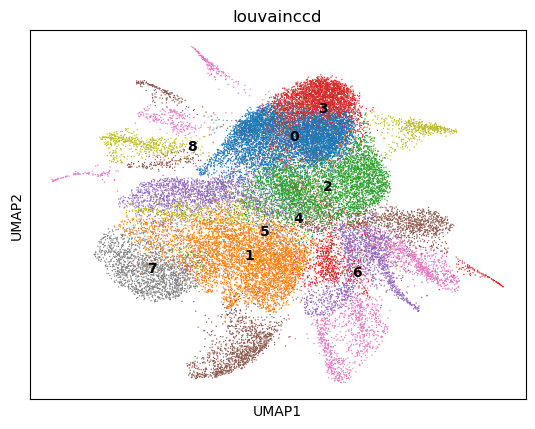

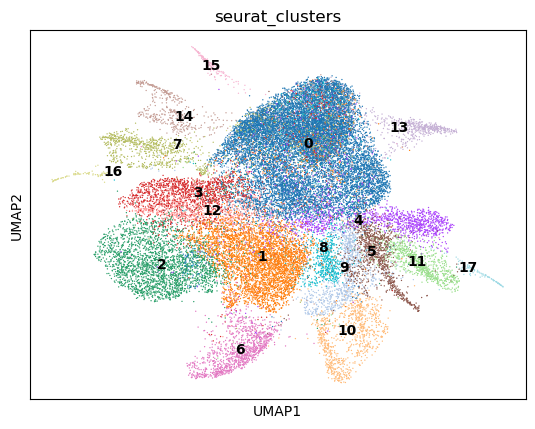

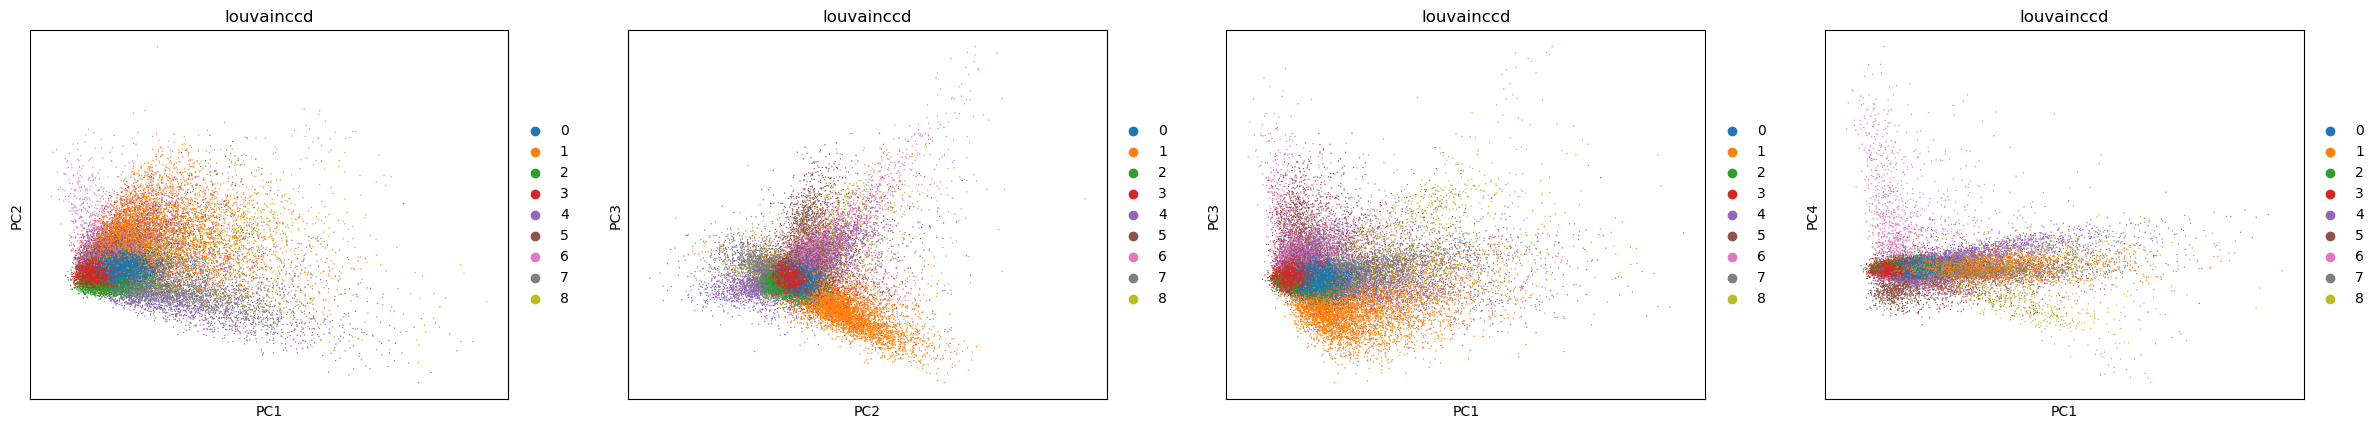

Adjusted Rand Index: 0.3623691284198085


In [19]:
from sklearn.metrics.cluster import adjusted_rand_score

# Assuming you have an 'adata' object with Louvain cluster assignments
import warnings
# Suppress specific warnings
# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata.obs['louvainStock'] = [str(i) for i in membership]
    # Calculate UMAP
    sc.tl.umap(adata)
    pcs_to_plot = ['1,2', '2,3', '1,3', '1, 4']
    # Plot UMAP with Louvain clusters
    sc.pl.umap(adata, color='louvainccd', legend_loc='on data')
    sc.pl.umap(adata, color='seurat_clusters', legend_loc='on data')
    sc.pl.pca(adata, color= 'louvainccd' , components = pcs_to_plot, show=True)

ari = adjusted_rand_score(membership,adata.obs['seurat_clusters'].tolist())
# Print the ARI
print("Adjusted Rand Index:", ari)

In [39]:
#Read in JTK results
aryth = pd.read_csv("Greenham/Data/GreenhamJTKNonCyclersBHQmoreThan2.csv")

#Select the first column with the gene names
no_cycle_genes = aryth.CycID

# Ensure the genes in the list are present in the anndata object
gene_list = [gene for gene in no_cycle_genes if gene in adata.var_names]

# Subset the anndata object
adata_noCycle = adata[:, gene_list].copy()

In [40]:
# Copy the 'counts' layer to 'X'
adata_noCycle.X = adata_noCycle.layers['counts'].copy()

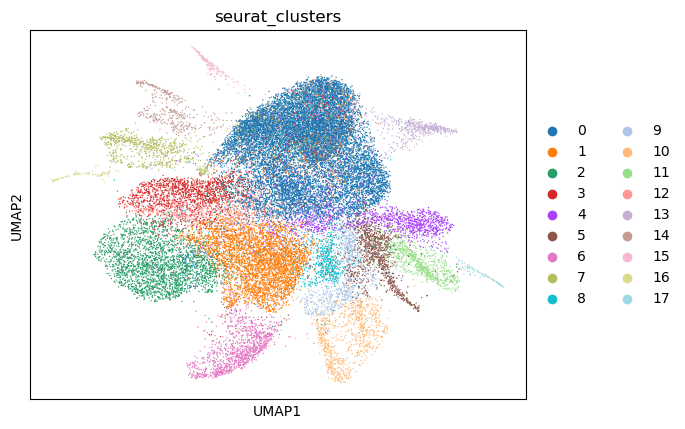

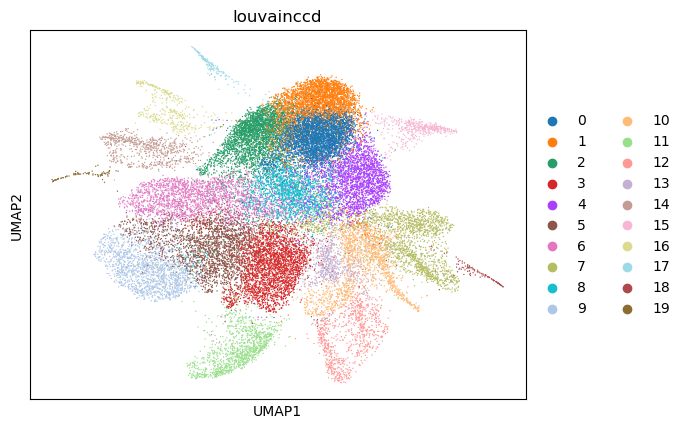

In [41]:
# # If UMAP has not been computed, compute it (optional)
# sc.pp.normalize_total(adata_noCycle, target_sum=1e4)

# # Log-transform the data
# sc.pp.log1p(adata_noCycle)

# # Scale the data to unit variance and zero mean
# sc.pp.scale(adata_noCycle, max_value=10)
# sc.pp.pca(adata_noCycle, n_comps=30)

# sc.pp.neighbors(adata_noCycle, use_rep = 'X_pca', n_neighbors= 20)
# sc.tl.umap(adata_noCycle)

# Plot the UMAP
sc.pl.umap(adata_noCycle, color='seurat_clusters')  # replace 'gene1', 'gene2' with the names of genes or metadata you want to color by
sc.pl.umap(adata_noCycle, color='louvainccd')  # replace 'gene1', 'gene2' with the names of genes or metadata you want to color by


Cluster 0 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 1 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 2 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 3 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 4 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 5 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 6 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 7 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 8 contains 14 samples
[[ 0  0  0 ... 13 13 13]]


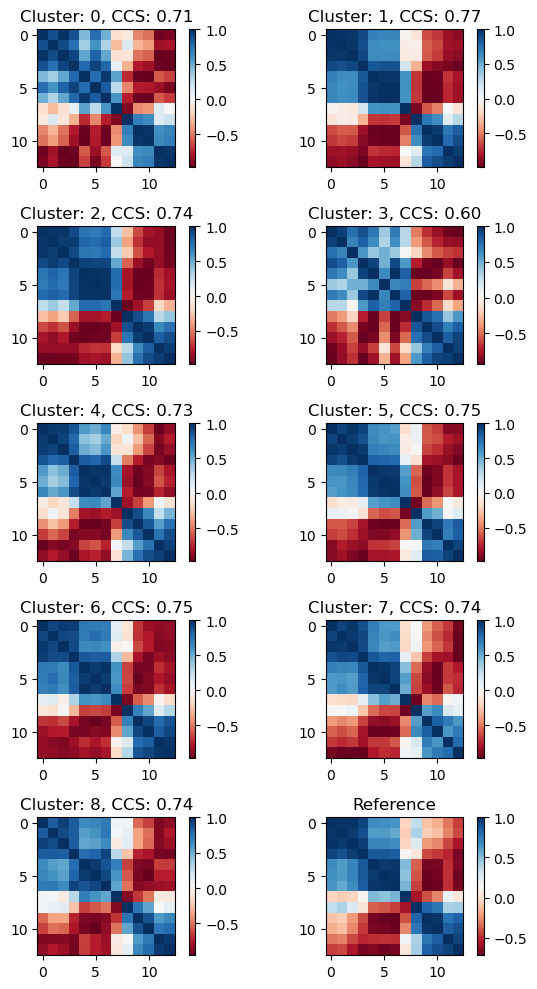

Cluster 0 contains 13 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 1 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 2 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 3 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 4 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 5 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 6 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 7 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 8 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 9 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 10 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 11 contains 14 samples
[[ 0  0  0 ... 13 13 13]]
Cluster 12 contains 14 samples
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1

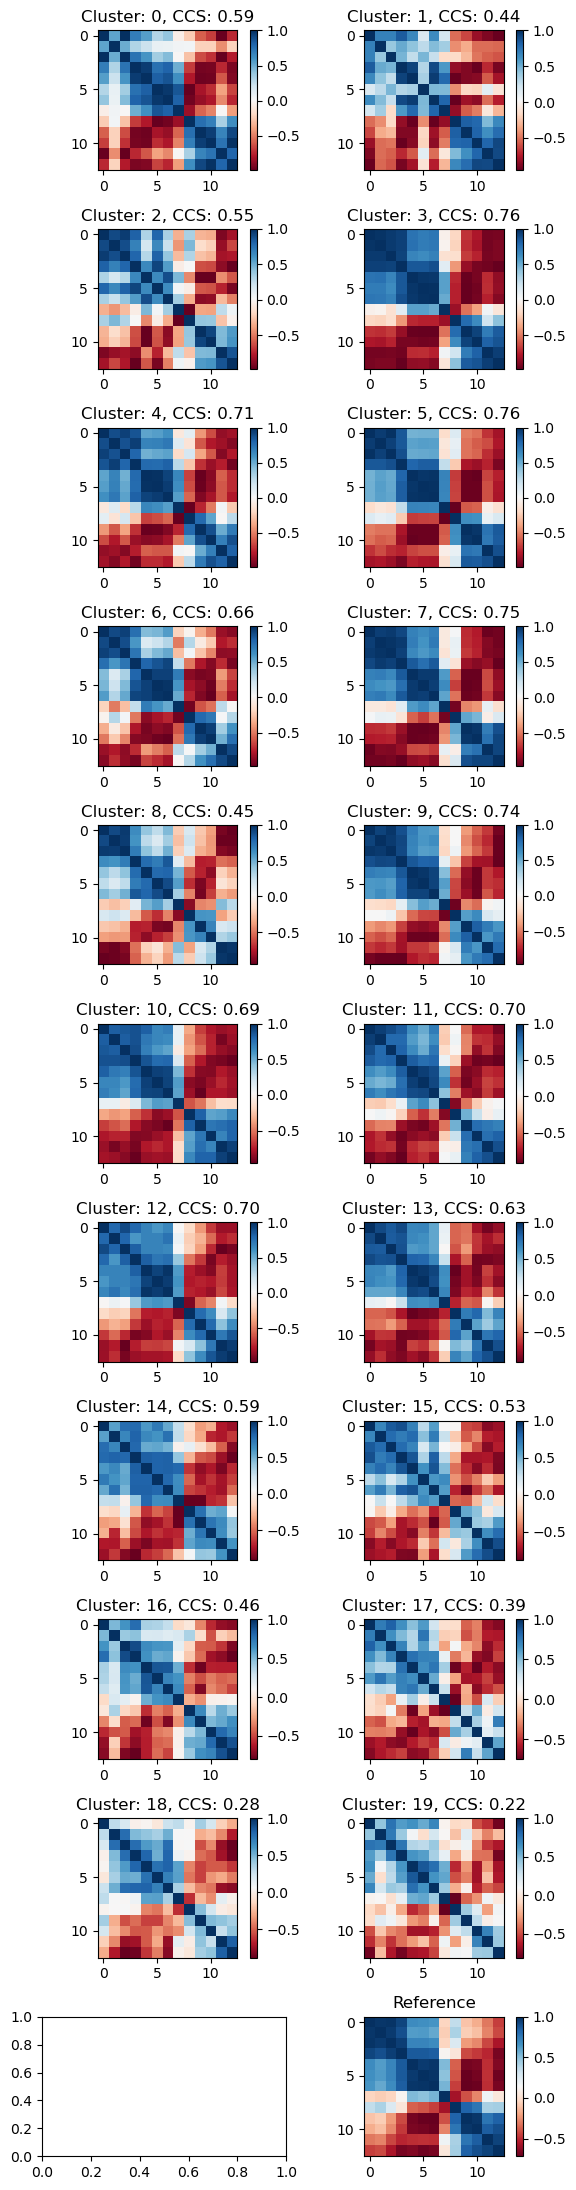

In [47]:
import matplotlib.pyplot as plt

def sumByGroup(matrix, groups):
    # Convert inputs to numpy arrays for easier manipulation
    matrix = np.array(matrix)
    groups = np.array(groups).flatten()
    
    # Get the unique groups
    unique_groups = np.unique(groups)
    
    # Initialize the result matrix with zeros
    result = np.zeros((matrix.shape[0], len(unique_groups)))
    
    # Sum the columns of the matrix according to the groups
    for i, group in enumerate(unique_groups):
        result[:, i] = matrix[:, groups == group].sum(axis=1)
    
    return result

def get_corgram(membership, clusterID):
    cluster_A_cells = [i for i in range(len(membership)) if membership[i] == clusterID]
    cluster_A_emat = adata.X.T[np.ix_(indices_list, cluster_A_cells)]
    clusterA_groups = [subjects[i] for i in cluster_A_cells]
    pseudoBulk = sumByGroup(cluster_A_emat, clusterA_groups)
    print("Cluster {} contains {} samples".format(clusterID, len(np.unique(clusterA_groups))))
    print(np.array(clusterA_groups).astype(np.int32).reshape(1, -1))
    ccs = louvain.calcCCS(refmat, cluster_A_emat, np.array(clusterA_groups).astype(np.int32).reshape(1, -1))
    # Get correlation matrix:
    corr_mat = np.array(scipy.stats.spearmanr(pseudoBulk.T))[0,:,:]
    return(corr_mat, ccs)

def plot_corgrams(membership):
    num_clusters = len(np.unique(membership))
    cols = 2
    rows = math.ceil((num_clusters+1) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6, rows*2))
    # Flatten the axes array
    axes = axes.flatten()

    # Iterate over the list and plot each item in a subplot
    for i in range(num_clusters):
        corgram, ccs = get_corgram(membership, i)
        heatmap = axes[i].imshow(corgram, cmap = "RdBu")
        axes[i].set_title('Cluster: {}, CCS: {:.4f}'.format(i, ccs))
        fig.colorbar(heatmap, ax=axes[i])

    heatmap_ref = axes[-1].imshow(refmat, cmap = "RdBu")
    axes[-1].set_title('Reference')
    fig.colorbar(heatmap_ref, ax=axes[-1])

    # # Hide any unused subplots
    # for j in range(i + 1, len(axes)):
    #     fig.delaxes(axes[j])

    # Display the plot
    plt.tight_layout()
    plt.show()

plot_corgrams(membership)
plot_corgrams(membership_louvainStock)